Датасет: [MotionSense Dataset](https://github.com/mmalekzadeh/motion-sense)

Содержит показания с частотой 50Гц

Активности: downstairs, upstairs, walking, jogging, sitting, and standing
Данные: "attitude", "gravity", "rotationRate", "userAcceleration":

Поле **id** отвечает за номер человека, который производил активность.


Скачаем этот датасет:

In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm_notebook
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt


drive.mount("/content/drive")

#warnings.simplefilter('ignore')

plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 8

Mounted at /content/drive


#### 1. Скачивание и распаковка датасета.

In [ ]:
!git clone https://github.com/mmalekzadeh/motion-sense.git

Cloning into 'motion-sense'...
remote: Enumerating objects: 612, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 612 (delta 4), reused 4 (delta 4), pack-reused 605
Receiving objects: 100% (612/612), 201.77 MiB | 24.03 MiB/s, done.
Resolving deltas: 100% (296/296), done.
Updating files: 100% (74/74), done.


разархивируем в content все его части (также есть на моем гугл-диске по адресу /content/drive/MyDrive/metric_analysis/datasets/motion-sense) (/content/)

In [ ]:
!cp /content/motion-sense/data/data_subjects_info.csv -d .
!unzip -q /content/motion-sense/data/A_DeviceMotion_data.zip -d .
!unzip -q /content/motion-sense/data/B_Accelerometer_data.zip -d .
!unzip -q /content/motion-sense/data/C_Gyroscope_data.zip -d .

In [ ]:
# !cp /content/motion-sense/data/* /content/drive/MyDrive/metric_analysis/datasets/motion-sense
# !unzip -q /content/drive/MyDrive/metric_analysis/datasets/motion-sense/A_DeviceMotion_data.zip -d /content/drive/MyDrive/metric_analysis/datasets/motion-sense/
# !unzip -q /content/drive/MyDrive/metric_analysis/datasets/motion-sense/B_Accelerometer_data.zip -d /content/drive/MyDrive/metric_analysis/datasets/motion-sense/
# !unzip -q /content/drive/MyDrive/metric_analysis/datasets/motion-sense/C_Gyroscope_data.zip -d /content/drive/MyDrive/metric_analysis/datasets/motion-sense/

Из датасета с большим количеством измерений берем только "userAcceleration" во время ходьбы "wlk"

In [ ]:
freq = 50 # частота замера = 50ГЦ

def get_ds_infos():
    """
    Read the file includes data subject information.
    
    Data Columns:
    0: code [1-24]
    1: weight [kg]
    2: height [cm]
    3: age [years]
    4: gender [0:Female, 1:Male]
    
    Returns:
        A pandas DataFrame that contains inforamtion about data subjects' attributes 
    """ 

    dss = pd.read_csv("data_subjects_info.csv")
    print("[INFO] -- Data subjects' information is imported.")
    
    return dss

def set_data_types(data_types=["userAcceleration"]):
    """
    Select the sensors and the mode to shape the final dataset.
    
    Args:
        data_types: A list of sensor data type from this list: [attitude, gravity, rotationRate, userAcceleration] 

    Returns:
        It returns a list of columns to use for creating time-series from files.
    """
    dt_list = []
    for t in data_types:
        if t != "attitude":
            dt_list.append([t+".x",t+".y",t+".z"])
        else:
            dt_list.append([t+".roll", t+".pitch", t+".yaw"])

    return dt_list


def creat_time_series(dt_list, act_labels, trial_codes, mode="mag", labeled=True):
    """
    Args:
        dt_list: A list of columns that shows the type of data we want.
        act_labels: list of activites
        trial_codes: list of trials
        mode: It can be "raw" which means you want raw data
        for every dimention of each data type,
        [attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)].
        or it can be "mag" which means you only want the magnitude for each data type: (x^2+y^2+z^2)^(1/2)
        labeled: True, if we want a labeld dataset. False, if we only want sensor values.

    Returns:
        It returns a time-series of sensor data.
    
    """
    num_data_cols = len(dt_list) if mode == "mag" else len(dt_list*3)

    if labeled:
        dataset = np.zeros((0,num_data_cols+7)) # "7" --> [act, code, weight, height, age, gender, trial] 
    else:
        dataset = np.zeros((0,num_data_cols))
        
    ds_list = get_ds_infos()
    
    print("[INFO] -- Creating Time-Series")
    for sub_id in ds_list["code"]:
        for act_id, act in enumerate(act_labels):
            for trial in trial_codes[act_id]:
                fname = 'A_DeviceMotion_data/'+act+'_'+str(trial)+'/sub_'+str(int(sub_id))+'.csv'
                raw_data = pd.read_csv(fname)
                raw_data = raw_data.drop(['Unnamed: 0'], axis=1)
                vals = np.zeros((len(raw_data), num_data_cols))
                for x_id, axes in enumerate(dt_list):
                    if mode == "mag":
                        vals[:,x_id] = (raw_data[axes]**2).sum(axis=1)**0.5        
                    else:
                        vals[:,x_id*3:(x_id+1)*3] = raw_data[axes].values
                    vals = vals[:,:num_data_cols]
                if labeled:
                    lbls = np.array([[act_id,
                            sub_id-1,
                            ds_list["weight"][sub_id-1],
                            ds_list["height"][sub_id-1],
                            ds_list["age"][sub_id-1],
                            ds_list["gender"][sub_id-1],
                            trial          
                           ]]*len(raw_data))
                    vals = np.concatenate((vals, lbls), axis=1)
                dataset = np.append(dataset,vals, axis=0)
    cols = []
    for axes in dt_list:
        if mode == "raw":
            cols += axes
        else:
            cols += [str(axes[0][:-2])]
            
    if labeled:
        cols += ["act", "id", "weight", "height", "age", "gender", "trial"]
    
    dataset = pd.DataFrame(data=dataset, columns=cols)
    return dataset
#________________________________


ACT_LABELS = ["dws","ups", "wlk", "jog", "std", "sit"]
TRIAL_CODES = {
    ACT_LABELS[0]:[1,2,11],
    ACT_LABELS[1]:[3,4,12],
    ACT_LABELS[2]:[7,8,15],
    ACT_LABELS[3]:[9,16],
    ACT_LABELS[4]:[6,14],
    ACT_LABELS[5]:[5,13]
}

## Here we set parameter to build labeld time-series from dataset of "(A)DeviceMotion_data"
## attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)
sdt = ["userAcceleration"] # attitude, gravity, rotationRate, userAcceleration
print("[INFO] -- Selected sensor data types: "+str(sdt))    
act_labels = ["wlk"] # ACT_LABELS [2:3]
print("[INFO] -- Selected activites: "+str(act_labels))    
trial_codes = [TRIAL_CODES[act] for act in act_labels]
dt_list = set_data_types(sdt)
print(dt_list)
dataset = creat_time_series(dt_list, act_labels, trial_codes, mode="raw", labeled=True)
print("[INFO] -- Shape of time-Series dataset:"+str(dataset.shape))    
dataset.head()

[INFO] -- Selected sensor data types: ['userAcceleration']
[INFO] -- Selected activites: ['wlk']
[['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']]
[INFO] -- Data subjects' information is imported.
[INFO] -- Creating Time-Series
[INFO] -- Shape of time-Series dataset:(344288, 10)


userAcceleration.x  userAcceleration.y  userAcceleration.z  act   id  \
0            0.091702            0.415881            0.093689  0.0  0.0   
1            0.367412            0.004566           -0.106082  0.0  0.0   
2            0.172093           -0.217483           -0.163387  0.0  0.0   
3            0.004957           -0.237566           -0.019080  0.0  0.0   
4           -0.040292           -0.241461            0.015201  0.0  0.0   

   weight  height   age  gender  trial  
0   102.0   188.0  46.0     1.0    7.0  
1   102.0   188.0  46.0     1.0    7.0  
2   102.0   188.0  46.0     1.0    7.0  
3   102.0   188.0  46.0     1.0    7.0  
4   102.0   188.0  46.0     1.0    7.0

Возьмем userAcceleration по x-y для id=0.0 (первый участник) и далее будем использовать его


In [ ]:
first_user_data = dataset[dataset['id'] == 0.0]
first_user_data

userAcceleration.x  userAcceleration.y  userAcceleration.z  act   id  \
0                0.091702            0.415881            0.093689  0.0  0.0   
1                0.367412            0.004566           -0.106082  0.0  0.0   
2                0.172093           -0.217483           -0.163387  0.0  0.0   
3                0.004957           -0.237566           -0.019080  0.0  0.0   
4               -0.040292           -0.241461            0.015201  0.0  0.0   
...                   ...                 ...                 ...  ...  ...   
11107            0.045689            0.611858           -0.873182  0.0  0.0   
11108            0.404748            1.027273           -0.621450  0.0  0.0   
11109            0.407576            0.258908           -0.084899  0.0  0.0   
11110            0.230798           -0.047420            0.175331  0.0  0.0   
11111           -0.183692           -0.401772            0.111459  0.0  0.0   

       weight  height   age  gender  trial  
0       102.0   188.0  46.0     1.0    7.0  
1       102.0   188.0  46.0     1.0    7.0  
2       102.0   188.0  46.0     1.0    7.0  
3       102.0   188.0  46.0     1.0    7.0  
4       102.0   188.0  46.0     1.0    7.0  
...       ...     ...   ...     ...    ...  
11107   102.0   188.0  46.0     1.0   15.0  
11108   102.0   188.0  46.0     1.0   15.0  
11109   102.0   188.0  46.0     1.0   15.0  
11110   102.0   188.0  46.0     1.0   15.0  
11111   102.0   188.0  46.0     1.0   15.0  

[11112 rows x 10 columns]

In [ ]:
first_user_data.describe()

userAcceleration.x  userAcceleration.y  userAcceleration.z      act  \
count        11112.000000        11112.000000        11112.000000  11112.0   
mean             0.059449            0.177968           -0.259180      0.0   
std              0.492574            0.639860            0.512329      0.0   
min             -3.330301           -1.645164           -2.616230      0.0   
25%             -0.226270           -0.314715           -0.573816      0.0   
50%              0.078264            0.139191           -0.226753      0.0   
75%              0.391761            0.601875            0.085896      0.0   
max              1.968308            2.708035            1.518116      0.0   

            id   weight   height      age   gender         trial  
count  11112.0  11112.0  11112.0  11112.0  11112.0  11112.000000  
mean       0.0    102.0    188.0     46.0      1.0      8.350252  
std        0.0      0.0      0.0      0.0      0.0      2.499083  
min        0.0    102.0    188.0     46.0      1.0      7.000000  
25%        0.0    102.0    188.0     46.0      1.0      7.000000  
50%        0.0    102.0    188.0     46.0      1.0      8.000000  
75%        0.0    102.0    188.0     46.0      1.0      8.000000  
max        0.0    102.0    188.0     46.0      1.0     15.000000

#### 2. Визуализация  данных

In [ ]:
x_acc = first_user_data['userAcceleration.x']
sec_times = np.arange(len(x_acc)) / freq

vis_mask = (sec_times < 10) # покажем только первые 10 сек

fig = go.Figure()
fig.add_trace(go.Scatter(x=sec_times[vis_mask],
                            y = x_acc[vis_mask],
                            mode='lines', 
                            name='x_acc'))

fig.update_layout(
    title="User#0 x-acceleration during walking",
    xaxis_title="time, sec",
    yaxis_title="Acceleration",
    legend_title="Legend Title",
    font=dict(
        family="DejaVu Serif",
        size=18,
        color="RebeccaPurple"
    )
)

fig.show()

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

Text(0.5, 1.0, 'Target autocorrelation')

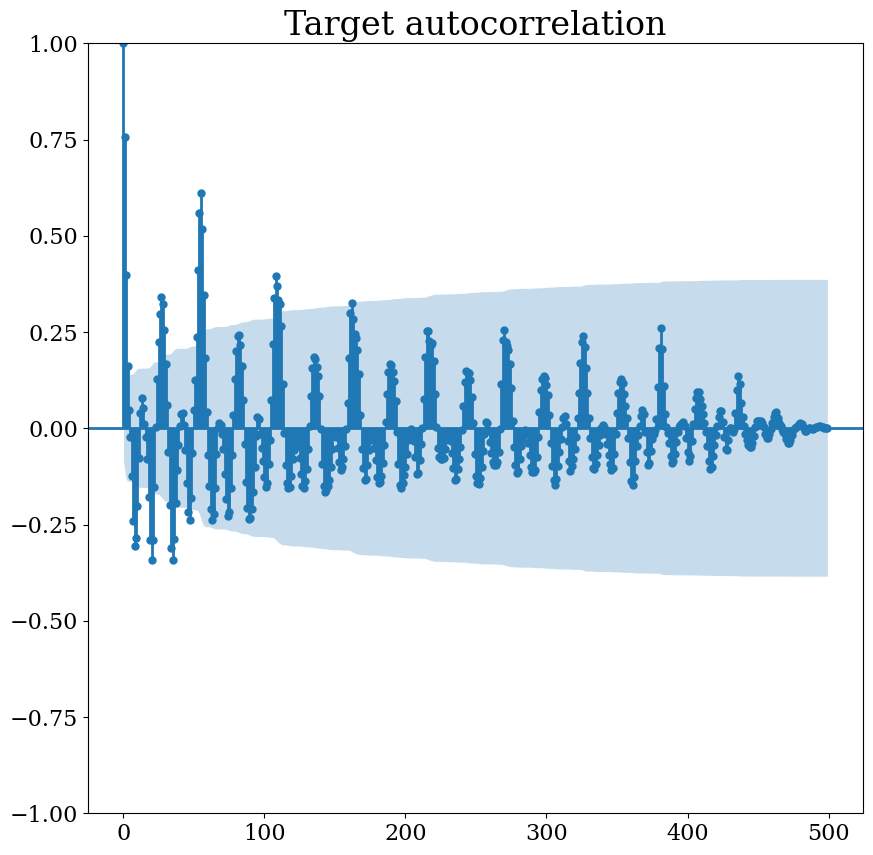

In [ ]:
x_acc_part = x_acc[:freq * 10] # 10 sec
plot_acf(x_acc_part, lags=len(x_acc_part) - 1);
x_ids = sec_times

#plt.xticks(x_ids, train_data.index[x_ids].map(lambda x: str(x)[:4]))
plt.title('Target autocorrelation')

#### 3. Изменение частоты и использование 2NN для восстановления

In [ ]:
!pip install geotorch -q

from drive.MyDrive.metric_analysis.modules.classes_and_functions import *
from drive.MyDrive.metric_analysis.modules.model_arch import *
from drive.MyDrive.metric_analysis.modules.visualization import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 kB 3.0 MB/s eta 0:00:00


Приближенно (да и из графика видно) считаем, что 1 шаг совершается за 1 секунду.

Тогда 2 шага занимают 2 секунды. Именно такое время мы и будем восстанавливать

In [ ]:
period = 2 # 2 секунды мы даем на вход модели

steps_in_time = period * freq # сколько моментов времени в периуде
print(steps_in_time)

100


**3-х мерная** модель.
Задаем архитектуру модели 100-3-100. 
Создаем датасет и даталоадер из временного ряда.

In [ ]:
in_len = steps_in_time
hid_dim = 3
out_len = steps_in_time

batch_size = 16
lr = 1e-3

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)

dataset = TimeSerie_1d_Dataset(in_len=in_len, 
                               out_len=out_len, 
                               s_noice=first_user_data['userAcceleration.x'], 
                               s_true=None)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = NN_2(in_len=in_len, hid_dim=hid_dim, out_len=out_len).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, threshold=0.001, verbose=True)

cpu


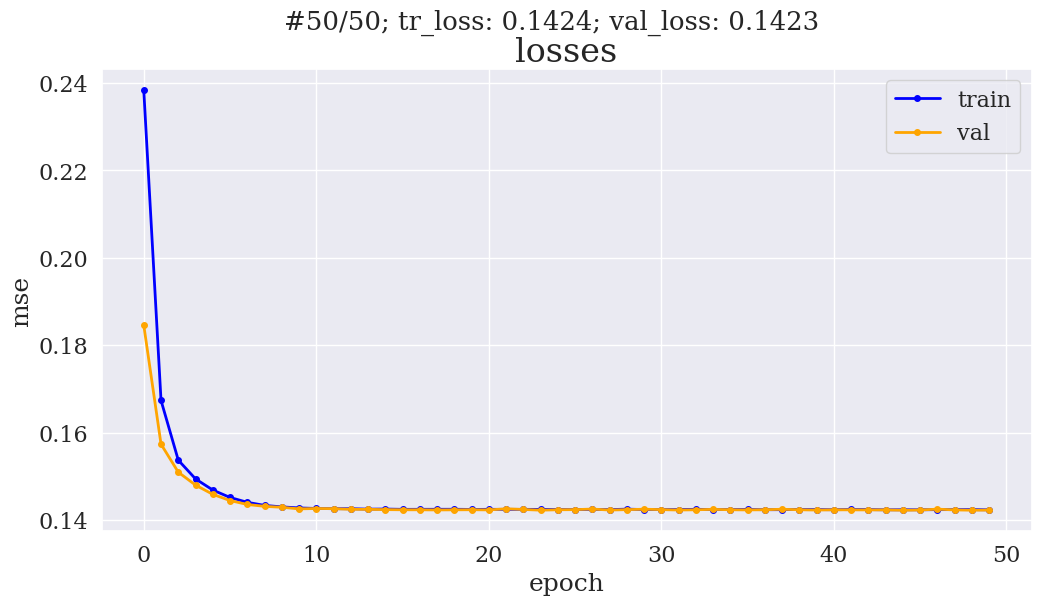

In [ ]:
model, optimizer, losses = learning_loop(
    model = model,
    optimizer = optimizer,
    loader = dataloader,
    criterion = criterion,
    epochs=50,
    draw_every=10,
    separate_show=False,
    device=device
)

In [ ]:
visualize_predictions_go(sec_times, first_user_data['userAcceleration.x'], model, dataset, batch_size, vis_time=10, device=device)

#### 4. Оценка ковариации вычислением Гессиана

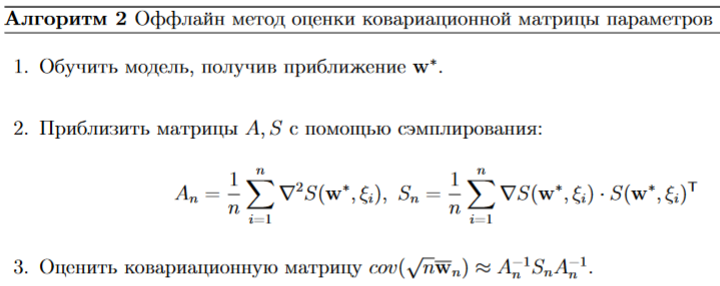

Я пренебрегу взаимодействиями между нейронами и буду для каждого нейрона отдельно считать гессиан и обращать.

Вопрос: а я могу поставить сразу батч? И получить уже усреденный Гессиан? - ДА! )быстрее намного будет)

**Сделать:** вычислять гессиан только по **1 параметру!** (по **1 строке**) - это намного быстрее и подходит для больших моделей.

**Сделать:** Оценить **доверительный интервал** для каждого параметра в матрице Гессе?

**ЗАмечание** В схеме $y=Wx+b$ (соответствует выходному слою) ВСЕ нейроны (строки $W$) будут иметь одинаковый Гессиан, равный $2xx^T$ (и возможно усредненный по $x$-ам).

Это в принципе логично! (так как завивисимость от весов модели - линейная). Это наверное ОК, ведь есть еще множитель $A_n$.

**Замечание** при подсчете $S_n$: не могу взять и усреднить по батчу 1 градиент: должен по каждой 1-це данных получить градиент и просуммировать их внешнее произведение.

**Замечание** по идее $S_n = 0$, так как является локальным минимумом?

**Код для вычисления матрицы ковариации одного параметра**

In [ ]:
import torch.nn.functional as F

In [ ]:
def calculate_2NN_function(tup):
    W1weight, W1bias, W2weight, W2bias = tup
    pars = [W1weight.view(model.hid_dim, model.in_len), 
            W1bias.view(model.hid_dim),
            W2weight.view(model.out_len, model.hid_dim),
            W2bias.view(model.out_len)]
    
    global in_data_to_hesssian

    out1 = F.linear(in_data_to_hesssian, pars[0], pars[1])
    out1 = F.relu(out1)
    out2 = F.linear(out1, pars[2], pars[3])
    
    return out2

In [ ]:
# подставляет в функцию ошибки наши данные
def wrapper_input_pars_2NN(in_data_to_hesssian, res_data_to_hessian):

    def calculate_2NN_function_loss_(W1weight, W1bias, W2weight, W2bias):
        pars = [W1weight.view(model.hid_dim, model.in_len), 
                W1bias.view(model.hid_dim),
                W2weight.view(model.out_len, model.hid_dim),
                W2bias.view(model.out_len)]
        # print(in_data_to_hesssian[0][0], res_data_to_hessian[0][0])

        out1 = F.linear(in_data_to_hesssian, pars[0], pars[1])
        out1 = F.relu(out1)
        out2 = F.linear(out1, pars[2], pars[3])

        loss = criterion(out2, res_data_to_hessian)

        return loss

    return calculate_2NN_function_loss_

In [ ]:
# вычисляет Гессиан для вторых производных по 1 параметру
def get_cov_for_parameters(h, params_shape, params_name):
    '''
        h - result of torch.autograd.functional.hessian
        params_shape - list with shapes
    '''

    assert len(h) == len(params_shape)

    res = {}
    for i in range(len(h)):
        hess = h[i][i]
        res[params_name[i]] = hess
    
    return res

In [ ]:
def get_per_neuron_hessian(hesian, par_shape):
    '''
        We look for parameter W[rows][cols] and want hessian for every row.
        hessian: [rows*cols, rows*cols]
        par_shape = (rows, cols)

        (not only hessian: but any subtatrixes)
    '''
    rows, cols = par_shape

    hessians = []

    for i in range(rows):
        id = i * cols
        hessians.append(hesian[id:id+cols, id:id+cols]) # 1 neuron by 1 neuron
    return hessians

In [ ]:
def get_hessians_by_rows(model, batch, wrapper_input_pars=wrapper_input_pars_2NN, device='cpu'):
    assert len(batch[0]) >= 100, "Not enough batch size to calculate Hessian"

    in_data_to_hesssian = batch[0].to(device)
    res_data_to_hessian = batch[1].to(device)
    h = torch.autograd.functional.hessian(wrapper_input_pars(in_data_to_hesssian.to(device), res_data_to_hessian.to(device)), tuple([_.view(-1) for _ in model.parameters()]))
    # print(tuple(par.shape for par in model.parameters()))
    # print(tuple(h[i][j].shape for i in range(len(h)) for j in range(len(h[i]))))
    
    named_pars = dict(model.named_parameters())
    par_names = list(named_pars.keys())

    covs = get_cov_for_parameters(h, tuple(par.shape for par in model.parameters()), par_names)

    result = dict()

    for par_name in par_names:
        if len(named_pars[par_name].shape) == 2: # now works only for Linear layers
            hesss = get_per_neuron_hessian(covs[par_name], named_pars[par_name].shape)

            result[par_name] = hesss
    return result

In [ ]:
from collections import defaultdict

def get_gradient_estimation(model, batch):
    '''
        Для каждого параметра вычисляет \sum grad @ grad^T (то есть матрицу)
        Теперь нужные матрицы - диагональные элементы!
    '''
    assert len(batch[0]) >= 100, "Not enough batch size to calculate Hessian"
    
    model.zero_grad()
    preds = model(batch[0].cuda()) # [batch_size, out_len]

    named_pars = dict(model.named_parameters())
    par_names = list(named_pars)

    pre_result = defaultdict(lambda: 0)
    
    for i in range(len(preds)):
        model.zero_grad()
        loss = criterion(preds[i], batch[1][i].cuda())
        loss.backward(retain_graph=True) # now have gradients

        for par_name in par_names:
            if len(named_pars[par_name].shape) == 2: # now works only for Linear layers
                first_part, second_part = par_name.split('.') # because they are 'W1.weight'
                gradient = getattr(getattr(model, first_part), second_part).grad # [rows, cols]

                # now - flatten! (= concat rows = neurons)
                gradient = gradient.view(-1, 1) # there was flatten!
                pre_result[par_name] += gradient @ gradient.T # now we need diagonal matrices


    for key in pre_result.keys():
        pre_result[key] /= len(preds)

    # сразу возвращаем только нужные подматрицы, соответствующие нейронам

    result = dict()
    # по ключу для каждого нейрона - оценка его матрицы S_n

    for par_name in par_names:
        if len(named_pars[par_name].shape) == 2: # now works only for Linear layers
            grads = get_per_neuron_hessian(pre_result[par_name], named_pars[par_name].shape)

            result[par_name] = grads
    
    return result

In [ ]:
def ger_hessian_for_flattened_parameters(model, batch, wrapper_input_pars=wrapper_input_pars_2NN):
    '''
        return: dict iwth keys=par.names, values = 2d matrix with hessian
    '''
    assert len(batch[0]) >= 100, "Not enough batch size to calculate Hessian"
    in_data_to_hesssian = batch[0].to(device)
    res_data_to_hessian = batch[1].to(device)
    
    h = torch.autograd.functional.hessian(wrapper_input_pars(in_data_to_hesssian.to(device), res_data_to_hessian.to(device)), tuple([_.view(-1) for _ in model.parameters()]))
    named_pars = dict(model.named_parameters())
    par_names = list(named_pars.keys())

    hessians = get_cov_for_parameters(h, tuple(par.shape for par in model.parameters()), par_names)

    return hessians

In [ ]:
def get_grad_for_flattened_parameters(model, batch):
    
    assert len(batch[0]) >= 100, "Not enough batch size to calculate Hessian"

    model.zero_grad()
    preds = model(batch[0].to(device)) # [batch_size, out_len]

    named_pars = dict(model.named_parameters())
    par_names = list(named_pars)

    pre_result = defaultdict(lambda: 0)
    
    for i in range(len(preds)):
        model.zero_grad()
        loss = criterion(preds[i], batch[1][i].to(device))
        loss.backward(retain_graph=True) # now have gradients

        for par_name in par_names:
            if len(named_pars[par_name].shape) == 2: # now works only for Linear layers
                first_part, second_part = par_name.split('.') # because they are 'W1.weight'
                gradient = getattr(getattr(model, first_part), second_part).grad # [rows, cols]

                # now - flatten! (= concat rows = neurons)
                gradient = gradient.view(-1, 1) # there was flatten!
                pre_result[par_name] += gradient @ gradient.T # now we need diagonal matrices


    for key in pre_result.keys():
        pre_result[key] /= len(preds)

    return pre_result

In [ ]:
batch_size = 256
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
batch = next(iter(dataloader))
hesss = get_hessians_by_rows(model, batch)

In [ ]:
hesss['W2.weight'][0]

tensor([[0.0017, 0.0006, 0.0002],
        [0.0006, 0.0009, 0.0003],
        [0.0002, 0.0003, 0.0003]])

Для проверки надежности оценим дисперсию и std у оценок ковариации нейронов выходного слоя (W2.weight).

Для этого пройдемся батчем по датасету (в shuffle=True) и запишем предсказания. Далее по каждой ячейке посчитаем дисперсию.

In [ ]:
# вычисление дисперсии оценки жлементов матрицы
from tqdm.auto import tqdm
res = []

for batch in tqdm(dataloader):
    if len(batch[0]) == batch_size:
        hesss = get_hessians_by_rows(model, batch)
        res.append(hesss['W2.weight'][0])

all_covs = torch.stack(res)
print(all_covs.shape)

means = all_covs.mean(axis=0)
sigmas = torch.sqrt(all_covs.var(axis=0))

percentage = sigmas / means * 100
print(percentage)

torch.Size([43, 3, 3])
tensor([[6.0156, 4.6550, 5.4135],
        [4.6550, 4.8272, 3.8976],
        [5.4135, 3.8976, 5.0024]], device='cuda:0')


In [ ]:
batch = next(iter(dataloader))
grad_est_res = get_gradient_estimation(model, batch)

**Странно!** ковариации у всех нейронов выходного слоя ОДИНАКОВЫЕ!!!

Теперь оценим ковариацию одного нейрона в выходном слое.

In [ ]:
batch = next(iter(dataloader))

grad_est_res = get_gradient_estimation(model, batch)
hesss = get_hessians_by_rows(model, batch)

In [ ]:
inv_hess = torch.linalg.inv(hesss['W2.weight'][0])

In [ ]:
neuron_covs = []

for i in range(100):
    inv_hess = torch.linalg.inv(hesss['W2.weight'][i])

    neuron_covs.append((inv_hess @ grad_est_res['W2.weight'][i] @ inv_hess).cpu().numpy())

neuron_covs = np.array(neuron_covs)

Теперь еще примем среднее = выученные параметры

In [ ]:
model.W2.weight.shape

torch.Size([100, 3])

In [ ]:
neuron_means = []

for i in range(100):
    neuron_means.append(model.W2.weight[i, :].detach().cpu().numpy())

Визуализация

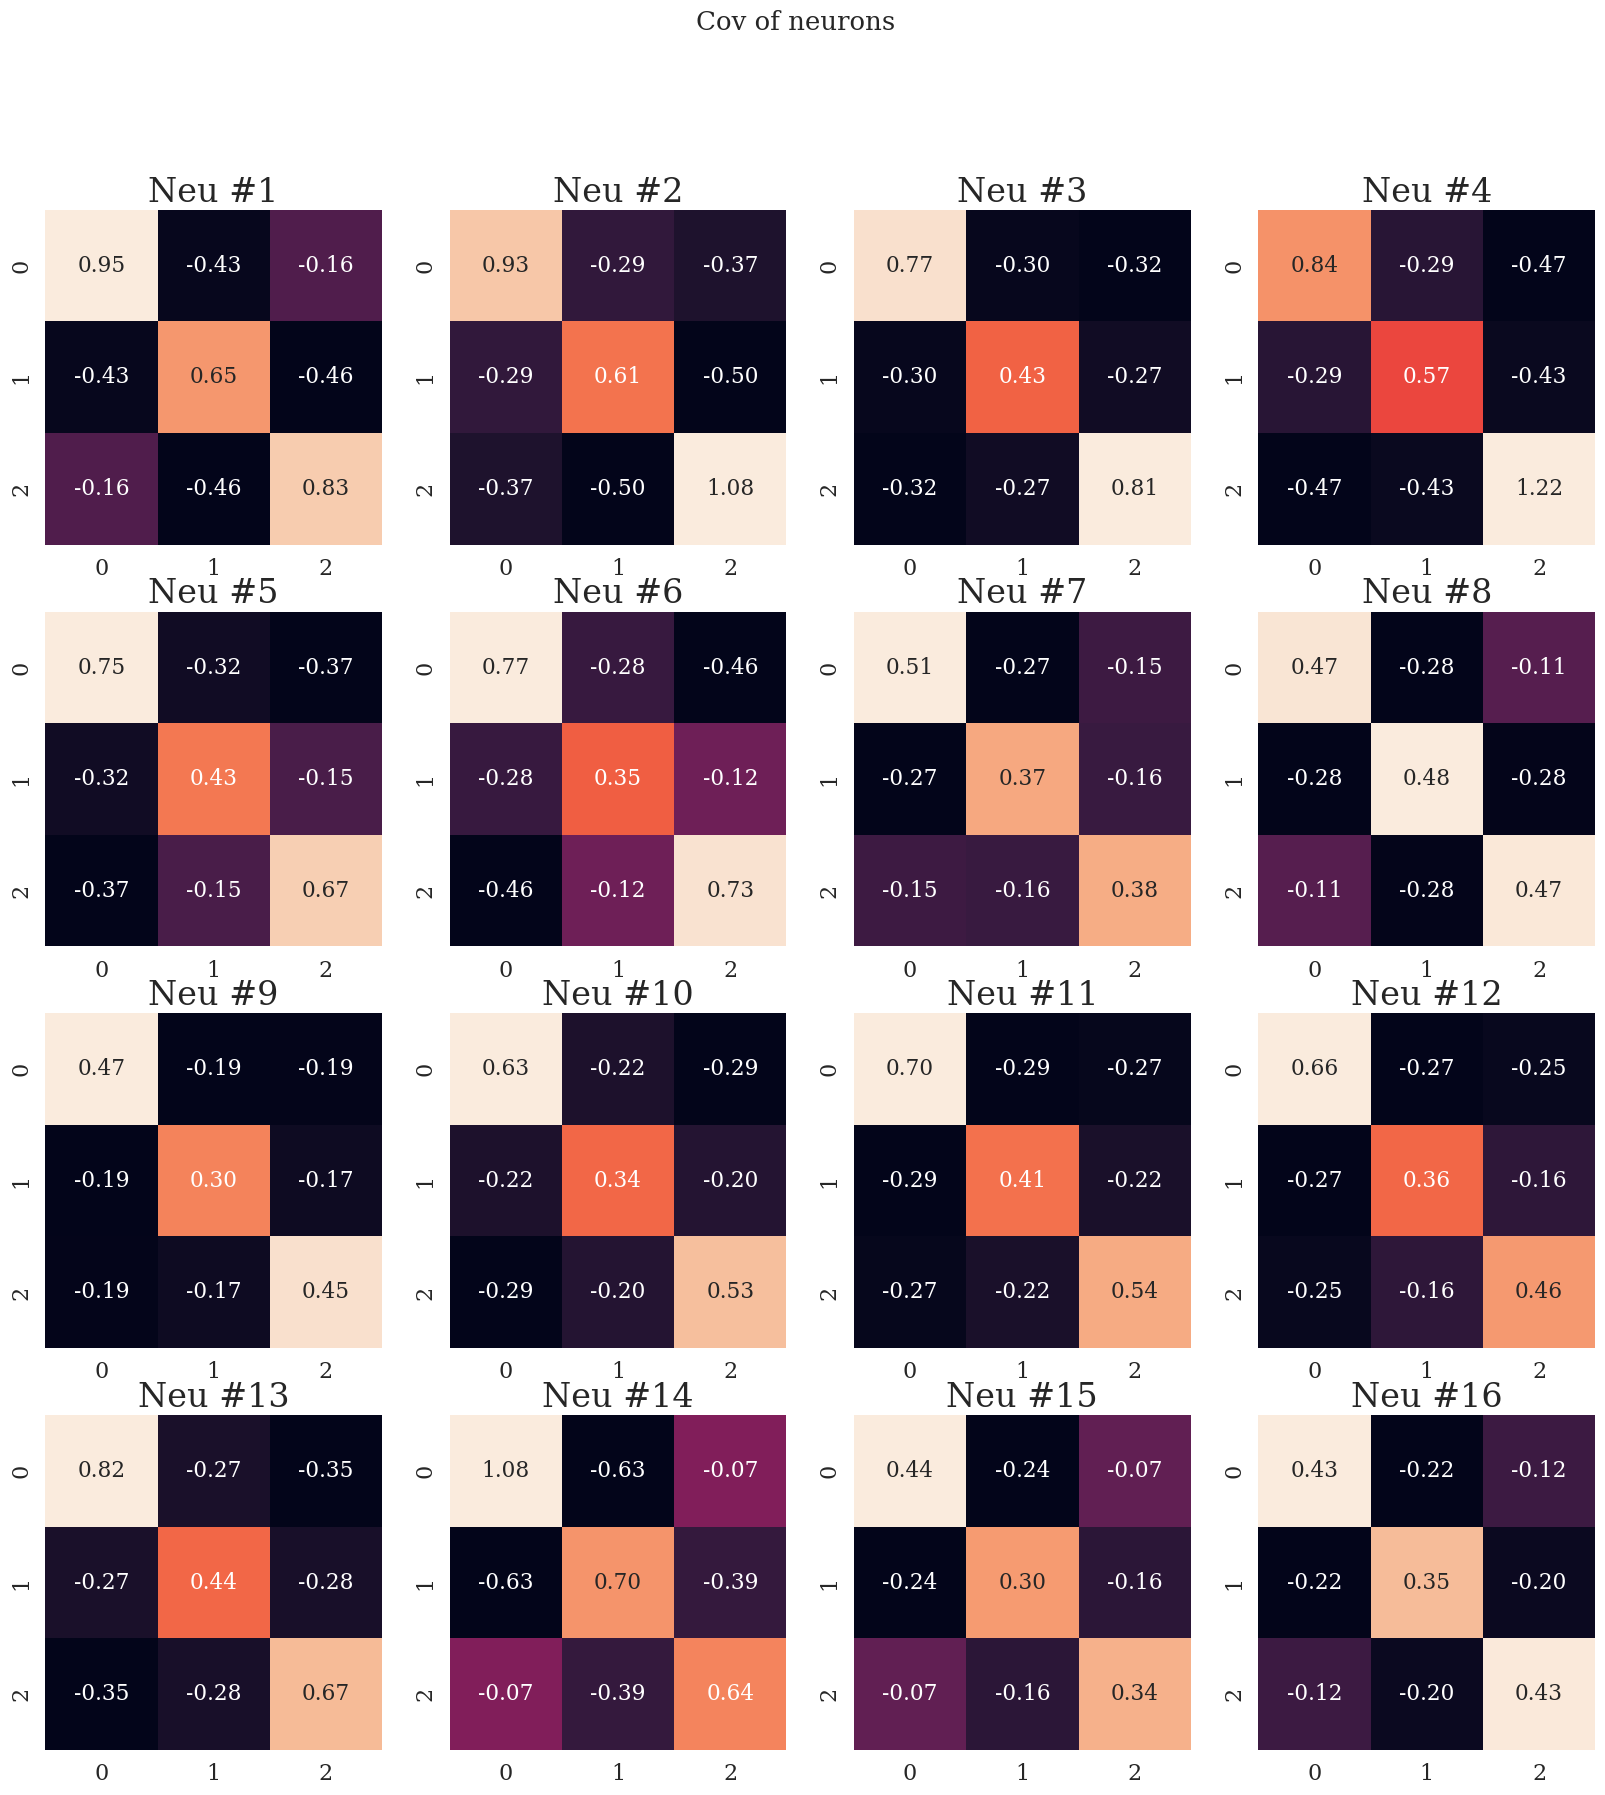

In [ ]:
plot_cov_heatmap(neuron_covs[:16])

In [ ]:
model.W2.weight.cpu().detach().numpy()[:10]

array([[-0.3904898 ,  0.49784636, -0.08281592],
       [-0.3727559 ,  0.47052515, -0.2756195 ],
       [-0.24328074,  0.4019637 , -0.46380273],
       [-0.02994087,  0.31341892, -0.6041305 ],
       [ 0.22117211,  0.22726823, -0.65906745],
       [ 0.4529475 ,  0.1652519 , -0.61936456],
       [ 0.6183666 ,  0.14218755, -0.49130097],
       [ 0.6830468 ,  0.15850954, -0.30709645],
       [ 0.6364245 ,  0.22062819, -0.09934688],
       [ 0.48179415,  0.31684634,  0.09327091]], dtype=float32)

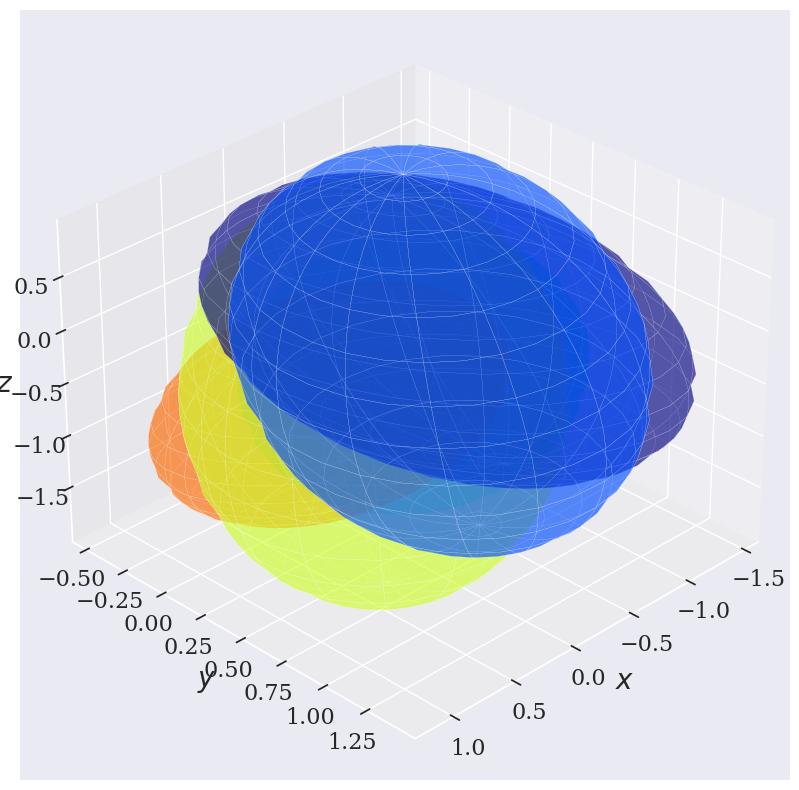

In [ ]:
plot_3d_gaussians(neuron_means[:5], neuron_covs[:5], alpha=1)

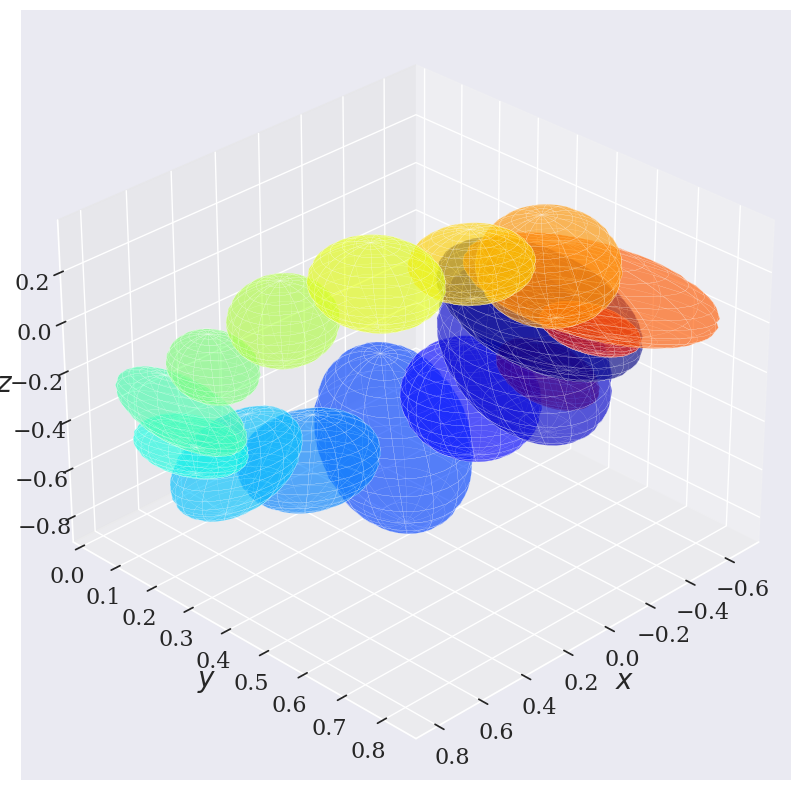

In [ ]:
plot_3d_gaussians(neuron_means[:16], neuron_covs[:16], alpha=0.2)

In [ ]:
plot_3d_gaussians_rot(model.W2.weight.cpu().detach().numpy()[:16], neuron_covs[:16], alpha=0.2, )

In [ ]:
cov = neuron_covs[0]
print(cov)
print(np.linalg.eig(cov)[0])

[[ 0.9469412  -0.43049076 -0.16401255]
 [-0.43049014  0.6461071  -0.45655635]
 [-0.16401297 -0.45655614  0.8280151 ]]
[0.05341684 1.0508492  1.3167974 ]


In [ ]:
print(np.linalg.eig(cov)[0])

[0.05341684 1.0508492  1.3167974 ]


In [ ]:
plot_3d_gaussians_rot(model.W2.weight.cpu().detach().numpy()[:5], neuron_covs[:5], alpha=1, )

Для оценки отдельно по каждому параметру (более слабое предположение)

In [ ]:
batch_size = 2048
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
batch = next(iter(dataloader))

In [ ]:
hess = ger_hessian_for_flattened_parameters(model, batch, wrapper_input_pars_2NN)

In [ ]:
assert hess['W1.weight'].shape == torch.Size([300, 300])

In [ ]:
grads = get_grad_for_flattened_parameters(model, batch)

In [ ]:
torch.linalg.det(grads['W1.weight'])

tensor(0.)

In [ ]:
torch.linalg.inv(grads['W1.weight'] + 1e-4 * torch.eye(300, 300))

tensor([[ 9.9586e+03, -3.5163e+01, -2.3792e+01,  ..., -8.1834e+00,
         -6.1710e+00,  7.9088e-01],
        [-3.5163e+01,  9.9520e+03, -4.0819e+01,  ..., -9.5491e+00,
         -6.2384e+00,  4.6247e-01],
        [-2.3792e+01, -4.0819e+01,  9.9479e+03,  ..., -8.2025e+00,
         -3.2202e+00,  2.7663e+00],
        ...,
        [-8.1834e+00, -9.5491e+00, -8.2025e+00,  ...,  9.7824e+03,
         -1.5625e+02, -9.2923e+01],
        [-6.1710e+00, -6.2384e+00, -3.2202e+00,  ..., -1.5625e+02,
          9.7906e+03, -1.5657e+02],
        [ 7.9088e-01,  4.6247e-01,  2.7663e+00,  ..., -9.2923e+01,
         -1.5657e+02,  9.7687e+03]])

In [ ]:
hess['W2.weight'][:6, :6]

tensor([[0.0199, 0.0261, 0.0178, 0.0000, 0.0000, 0.0000],
        [0.0261, 0.0444, 0.0271, 0.0000, 0.0000, 0.0000],
        [0.0178, 0.0271, 0.0212, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0199, 0.0261, 0.0178],
        [0.0000, 0.0000, 0.0000, 0.0261, 0.0444, 0.0271],
        [0.0000, 0.0000, 0.0000, 0.0178, 0.0271, 0.0212]])

In [ ]:
torch.linalg.det(grads['W2.weight'])

tensor(0.)

In [ ]:
grads['W2.weight'].shape

torch.Size([300, 300])

In [ ]:
invmatrix = torch.linalg.inv(grads['W2.weight'] + torch.eye(300, 300)) #1e-4 * torch.eye(300, 300)

In [ ]:
covs = invmatrix @ hess['W2.weight'] @ invmatrix

In [ ]:
neu_covs = []
for i in range(100):
    neu_covs.append(covs[i*3:i*3+3, i*3:i*3+3])

In [ ]:
neu_covs[0]

tensor([[0.0199, 0.0260, 0.0178],
        [0.0260, 0.0444, 0.0271],
        [0.0178, 0.0271, 0.0212]])

In [ ]:
neu_covs[-1]

tensor([[0.0199, 0.0260, 0.0178],
        [0.0260, 0.0444, 0.0271],
        [0.0178, 0.0271, 0.0212]])

In [ ]:
ger_hessian_for_flattened_parameters
get_grad_for_flattened_parameters

#### 4. Попробуем 2-х слойную нейросеть архитектуры 100-3-20-100

In [ ]:
class NN_3(nn.Module):
    def __init__(self, sizes=[100, 3, 100]):
        '''
            2-х слойная полносвязная сеть без ортогонализации
            Linear->ReLU->Linear
        '''
        super().__init__()
        self.in_len = sizes[0]
        self.hid_dim1 = sizes[1]
        self.hid_dim2 = sizes[2]
        self.out_len = sizes[3]

        self.sizes = sizes
        
        # One line suffices: Instantiate a linear layer with orthonormal columns
        self.W1 = nn.Linear(self.in_len, self.hid_dim1, bias=True)
        self.act1 = nn.ReLU()
        self.W2 = nn.Linear(self.hid_dim1, self.hid_dim2, bias=True)
        self.act2 = nn.ReLU()
        self.W3 = nn.Linear(self.hid_dim2, self.out_len, bias=True)
        self.act3 = nn.Identity()


    def forward(self, x):
        # self.linear is orthogonal and every 3x3 kernel in self.cnn is of rank 1
        x = self.W1(x)
        x = self.act1(x)

        x = self.W2(x)
        x = self.act2(x)

        x = self.W3(x)
        x = self.act3(x)

        return x

In [ ]:
# подставляет в функцию ошибки наши данные
def wrapper_input_pars_3NN(in_data_to_hesssian, res_data_to_hessian):

    def calculate_3NN_function_loss_(W1weight, W1bias, W2weight, W2bias, W3weight, W3bias):
        # print(model.sizes)
        pars = [W1weight.view(model.sizes[1], model.sizes[0]), 
                W1bias.view(model.sizes[1]),
                W2weight.view(model.sizes[2], model.sizes[1]),
                W2bias.view(model.sizes[2]),
                W3weight.view(model.sizes[3], model.sizes[2]),
                W3bias.view(model.sizes[3])]
        # print(in_data_to_hesssian[0][0], res_data_to_hessian[0][0])

        out1 = F.linear(in_data_to_hesssian, pars[0], pars[1])
        out1 = F.relu(out1)
        out2 = F.linear(out1, pars[2], pars[3])
        out2 = F.relu(out2)

        out3 = F.linear(out2, pars[4], pars[5])

        loss = criterion(out3, res_data_to_hessian)

        return loss

    return calculate_3NN_function_loss_

In [ ]:
period = 2 # 2 секунды мы даем на вход модели

steps_in_time = period * freq # сколько моментов времени в периуде
print(steps_in_time)

100


In [ ]:
in_len = steps_in_time
hid_dim = 3
out_len = steps_in_time

batch_size = 16
lr = 1e-3

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)

dataset = TimeSerie_1d_Dataset(in_len=in_len, 
                               out_len=out_len, 
                               s_noice=first_user_data['userAcceleration.x'], 
                               s_true=None)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = NN_3(sizes=[100, 3, 20, 100]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, threshold=0.001, verbose=True)

cuda:0


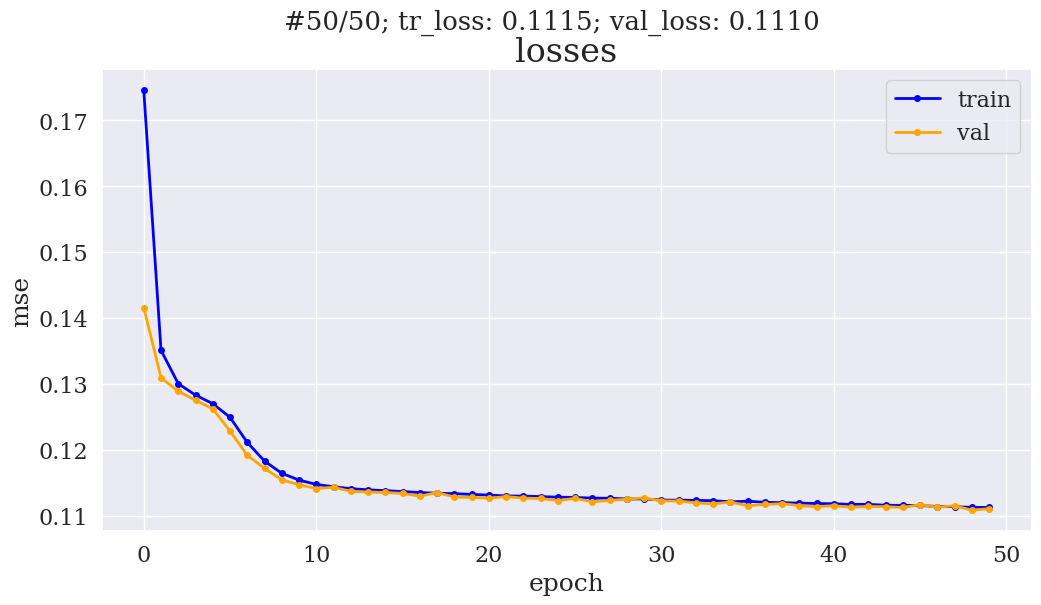

In [ ]:
model, optimizer, losses = learning_loop(
    model = model,
    optimizer = optimizer,
    loader = dataloader,
    criterion = criterion,
    epochs=50,
    draw_every=10,
    separate_show=False,
    device=device
)

In [ ]:
len(dataset)

NameError: ignored

In [ ]:
visualize_predictions_go(sec_times, first_user_data['userAcceleration.x'], model, dataset, batch_size, vis_time=10, device=device)

In [ ]:
batch_size = 256
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
batch = next(iter(dataloader))
hesss = get_hessians_by_rows(model, batch, wrapper_input_pars_3NN)

[100, 3, 20, 100]


In [ ]:
hesss['W2.weight'][0]

tensor([[0.2618, 0.2609, 0.2261],
        [0.2609, 0.4371, 0.3225],
        [0.2261, 0.3225, 0.3448]], device='cuda:0')

Для проверки надежности оценим дисперсию и std у оценок ковариации нейронов выходного слоя (W2.weight).

Для этого пройдемся батчем по датасету (в shuffle=True) и запишем предсказания. Далее по каждой ячейке посчитаем дисперсию.

In [ ]:
# вычисление дисперсии оценки жлементов матрицы
from tqdm.auto import tqdm
res = []

for batch in tqdm(dataloader):
    if len(batch[0]) == batch_size:
        hesss = get_hessians_by_rows(model, batch, wrapper_input_pars_3NN)
        res.append(hesss['W2.weight'][0])

all_covs = torch.stack(res)
print(all_covs.shape)

means = all_covs.mean(axis=0)
sigmas = torch.sqrt(all_covs.var(axis=0))

percentage = sigmas / means * 100
print(percentage)

In [ ]:
batch = next(iter(dataloader))
grad_est_res = get_gradient_estimation(model, batch)

**Странно!** ковариации у всех нейронов выходного слоя ОДИНАКОВЫЕ!!!

Теперь оценим ковариацию одного нейрона в выходном слое.

In [ ]:
batch = next(iter(dataloader))

grad_est_res = get_gradient_estimation(model, batch)
hesss = get_hessians_by_rows(model, batch, wrapper_input_pars_3NN)

[100, 3, 20, 100]


In [ ]:
hesss['W2.weight']

In [ ]:
inv_hess = torch.linalg.inv(hesss['W2.weight'][0])

In [ ]:
neuron_covs = []
bad_ids = []
good_ids = []

for i in range(len(hesss['W2.weight'])):
    try:
        inv_hess = torch.linalg.inv(hesss['W2.weight'][i])
        neuron_covs.append((inv_hess @ grad_est_res['W2.weight'][i] @ inv_hess).cpu().numpy())
        good_ids.append(i)
    except:
        bad_ids.append(i)

    
neuron_covs = np.array(neuron_covs)

Теперь еще примем среднее = выученные параметры

In [ ]:
model.W2.weight.shape

torch.Size([20, 3])

In [ ]:
neuron_means = []

for i in range(len(hesss['W2.weight'])):
    if i in good_ids:
        neuron_means.append(model.W2.weight[i, :].detach().cpu().numpy())

Визуализация

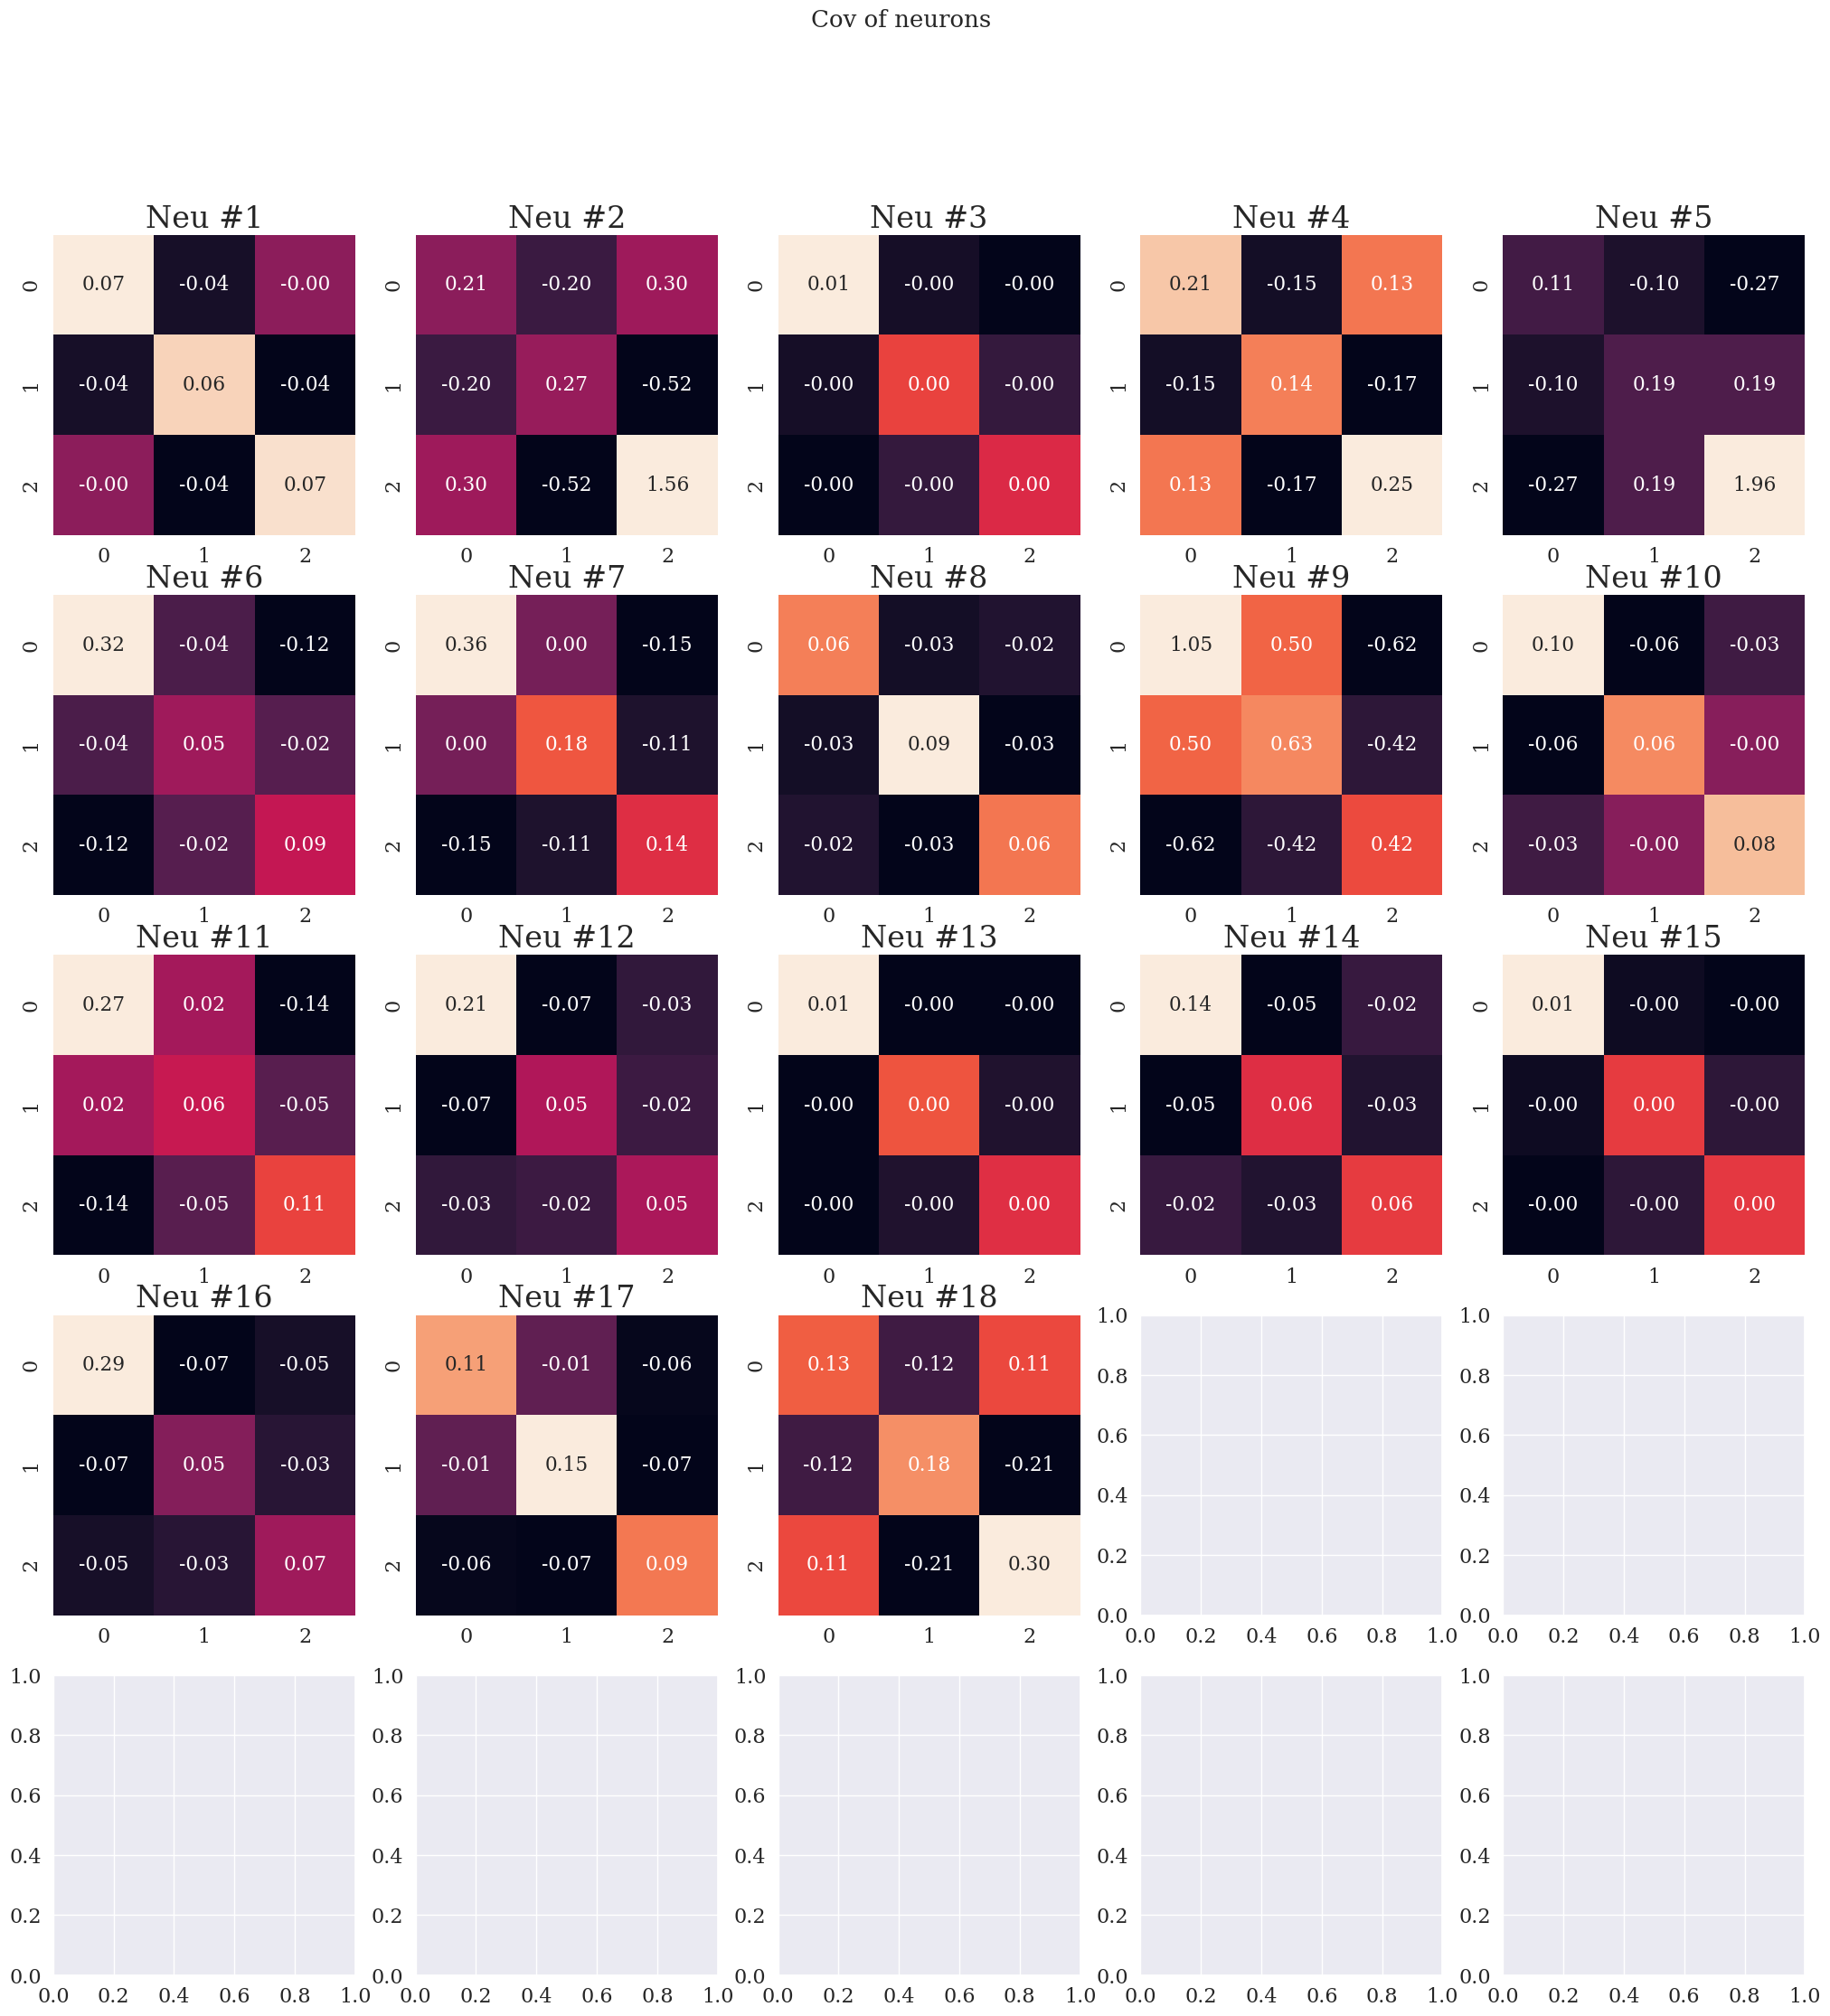

In [ ]:
plot_cov_heatmap(neuron_covs)

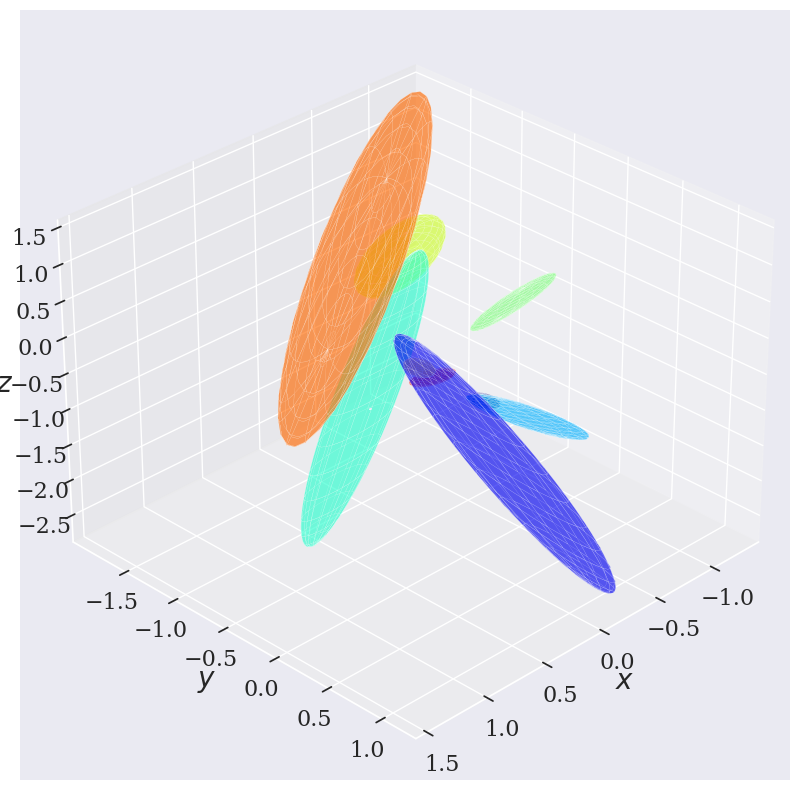

In [ ]:
plot_3d_gaussians(neuron_means[:10], neuron_covs[:10], alpha=1)

In [ ]:
cov = neuron_covs[0]
print(cov)
print(np.linalg.eig(cov))

[[ 0.06807701 -0.03585911 -0.00348465]
 [-0.03585911  0.06114134 -0.04232924]
 [-0.00348465 -0.04232923  0.06503408]]
(array([0.00651492, 0.07024028, 0.11749722], dtype=float32), array([[ 0.44570145,  0.76108515,  0.47127452],
       [ 0.71250767,  0.01709756, -0.70145607],
       [ 0.5419253 , -0.6484266 ,  0.5346585 ]], dtype=float32))


In [ ]:
plot_3d_gaussians_rot(neuron_means[:10], neuron_covs[:10], alpha=1)

Теперь: может быть мы неправы в предположении о том, что градиенты для различных нейронов независимы. 

Заменим его на более слабое - для разных ПАРАМЕТРОВ независимы и обращать будем матрицы параметров.

Аналогично будем использовать всю матрицу Гессе для параметра, а не только для 1 нейрона!

#### 4. Оценка ковариации нейронов модели САМЫМ простым методом

Суть в следующем: для модели 
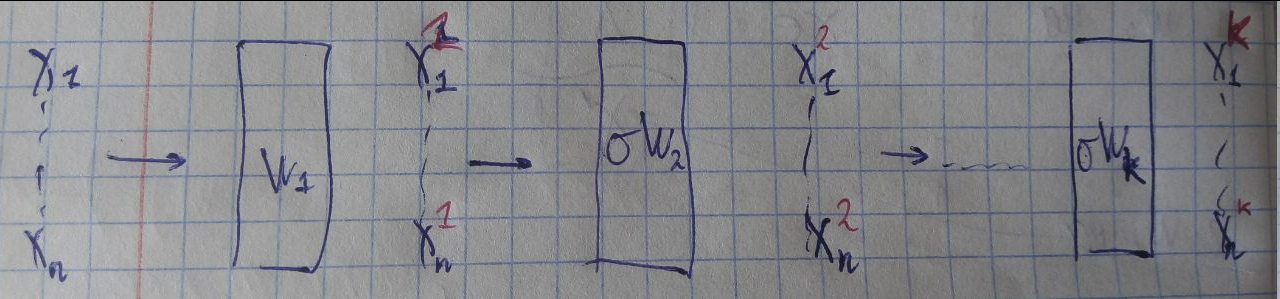

Мы хотим посчитать матрицу ковариаций для каждой строки, например $\mathbf{w}_1$.


Алгоритм:

1. Семплируем $N=100$ точек $(\mathbf{x}_1, \dots, \mathbf{x}_n)$ на вход (и считаем из iid)
2. Прогоняем через первый ($n-$ый) линейный слой, получаем точки $(\mathbf{y_1}, \dots, \mathbf{y}_n)$
3. Берем $i$-ую координату у всех $\mathbf{y}$ (она обусловлена действием нейрона $\mathbf{w}_i$ соответствующего слоя).
4. Считаем, что $cov(\mathbf{w}_i) \sim \mathbf{Y}_i\mathbf{Y}_i^T$ (это и есть вычисление ковариаций).

In [ ]:
class NN_with_instance_vars()

Теперь визуализируем нейроны: у них очень малая дисперсия!!!

In [ ]:
path = '/content/drive/MyDrive/metric_analysis/2NN_nonort_experiment_accel_3d'
!mkdir $path # создание папка
N = 100
max_epochs = 10

# Обучение моделей

models = []
losses = []

for i in tqdm_notebook(range(N)):
    model = NN_2(in_len=in_len, hid_dim=hid_dim, out_len=out_len).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    model, optimizer, losses_tr = learning_loop(
        model = model,
        optimizer = optimizer,
        loader = dataloader,
        criterion = criterion,
        epochs = max_epochs,
        val_every=max_epochs+1, 
        draw_every=max_epochs+1,
        separate_show=False,
        device=device
    )

    models.append(model)
    losses.append(losses_tr['train'][-1])
    print(f'Loss #{i + 1}: {losses_tr["train"][-1]:.3f}')

    torch.save(model.state_dict(), path + f"/nn_{i + 1}.pth")

In [ ]:
# загрузка моделей

models = []

for i in range(1, N + 1):
    model = NN_2(in_len=in_len, hid_dim=hid_dim, out_len=out_len).to(device)
    model.load_state_dict(torch.load(path + f'/nn_{i}.pth'))
    models.append(model)

In [ ]:
W1_matrices = np.array([models[i].W1.weight.detach().cpu().numpy() for i in range(len(models))])
print(W1_matrices.shape)

means = W1_matrices.mean(axis=0).T
variances = np.array([np.cov(W1_matrices[:, :, i], rowvar=False) for i in range(in_len)])
correlations = np.array([np.corrcoef(W1_matrices[:, :, i], rowvar=False) for i in range(in_len)])
print(means.shape, variances.shape)

(100, 3, 100)
(100, 3) (100, 3, 3)


In [ ]:
variances[0]

array([[0.0007929 , 0.00024053, 0.00028408],
       [0.00024053, 0.00054374, 0.00015898],
       [0.00028408, 0.00015898, 0.00061599]])

In [ ]:
import seaborn as sns

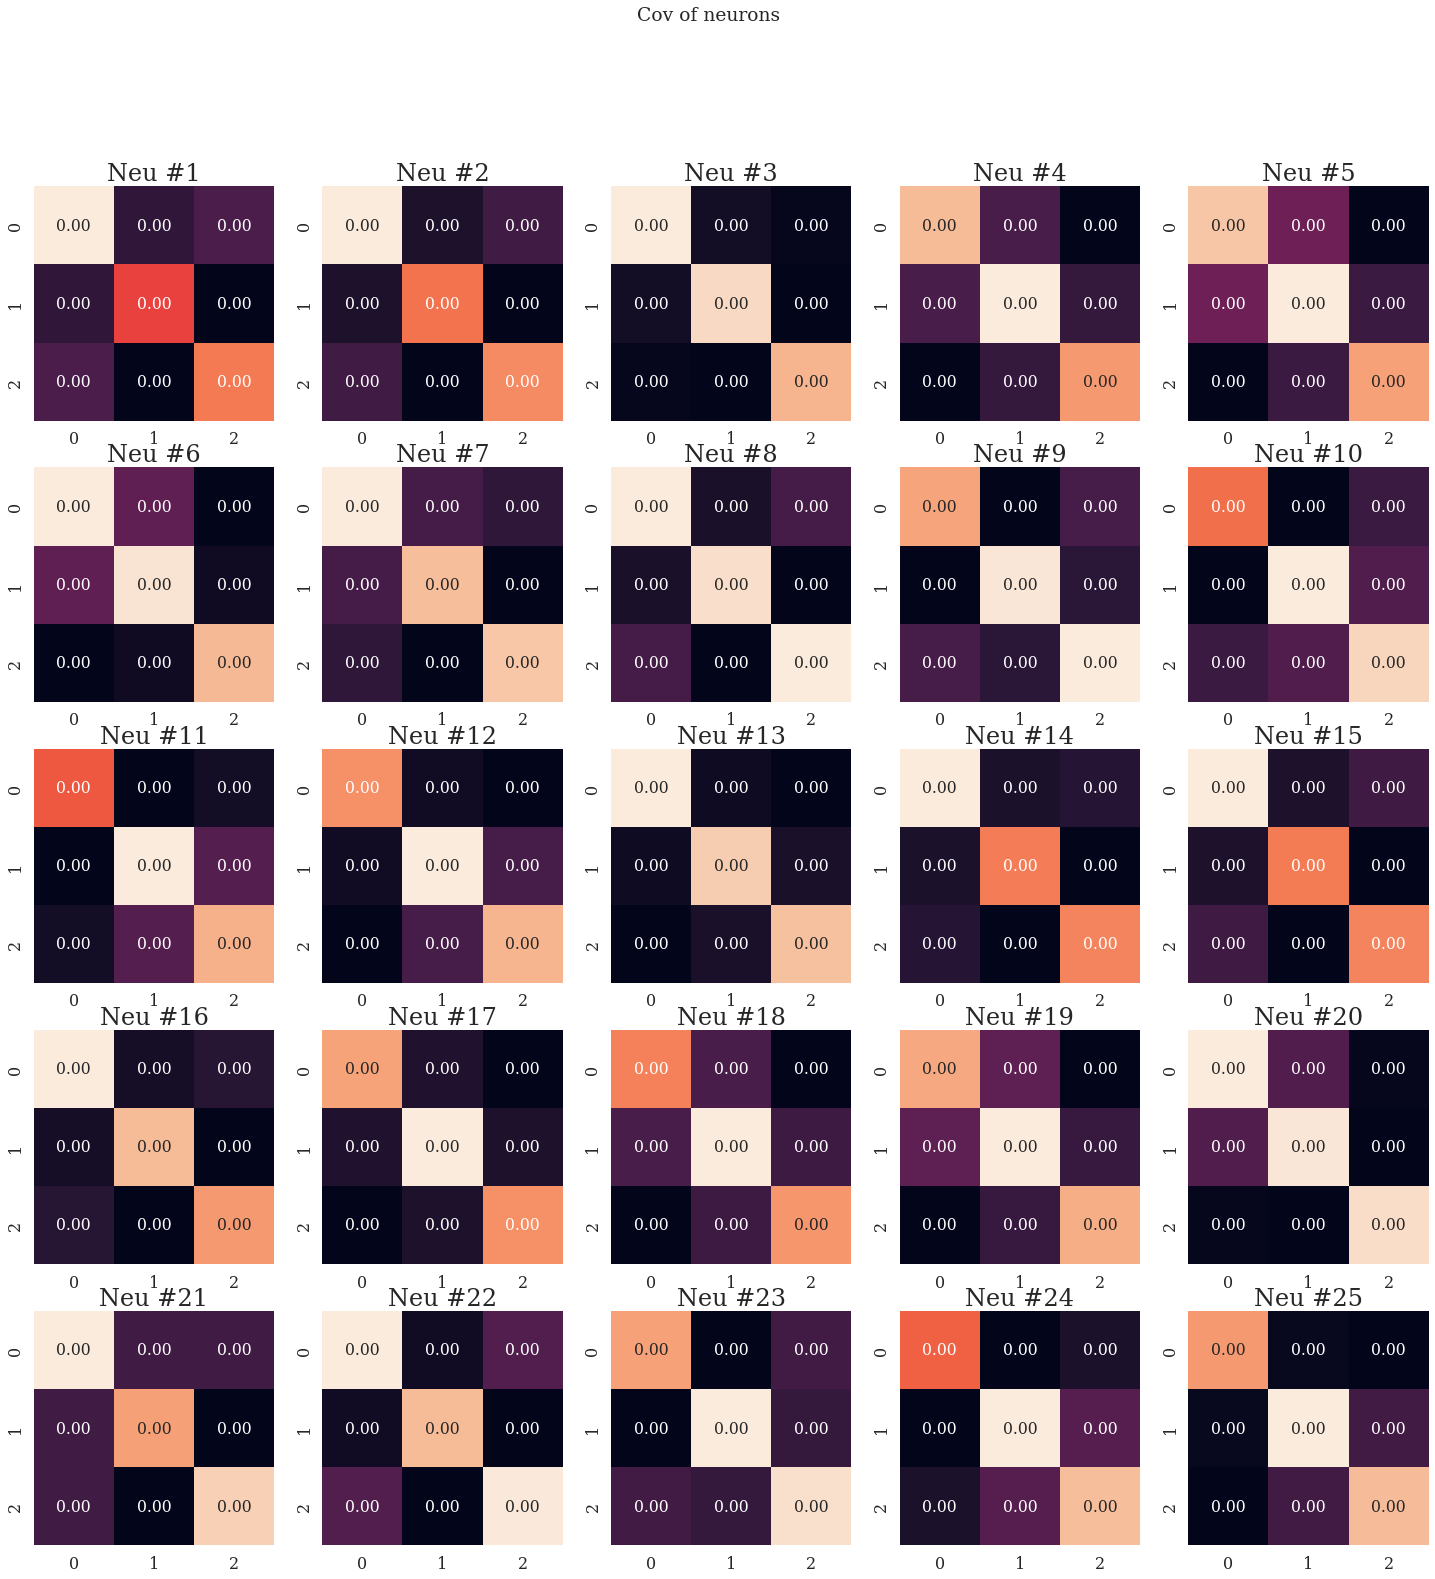

In [ ]:
plot_cov_heatmap(variances[:25], path_to_save='/content/drive/MyDrive/metric_analysis/plots/2nn', 
                  img_name='2NN_nonort_experiment_accel_3d')

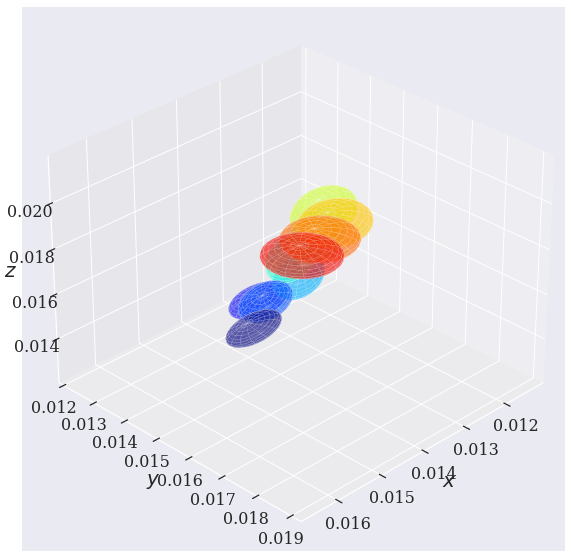

In [ ]:
plot_3d_gaussians(means[:10], variances[:10], alpha=1,
                  path_to_save='/content/drive/MyDrive/metric_analysis/plots/2nn', 
                  img_name='2NN_nonort_experiment_accel_3d_alpha=1')

In [ ]:
plot_3d_gaussians_rot(means[:10], variances[:10], alpha=1, path_to_save='/content/drive/MyDrive/metric_analysis/plots/2nn', 
                  img_name='2NN_nonort_experiment_accel_3d_alpha=1_plotly')

Теперь попробуем 5-мерную

In [ ]:
in_len = steps_in_time
hid_dim = 5
out_len = steps_in_time

batch_size = 16
lr = 1e-3

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)

dataset = TimeSerie_1d_Dataset(in_len=in_len, 
                               out_len=out_len, 
                               s_noice=first_user_data['userAcceleration.x'], 
                               s_true=None)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = NN_2(in_len=in_len, hid_dim=hid_dim, out_len=out_len).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

cpu


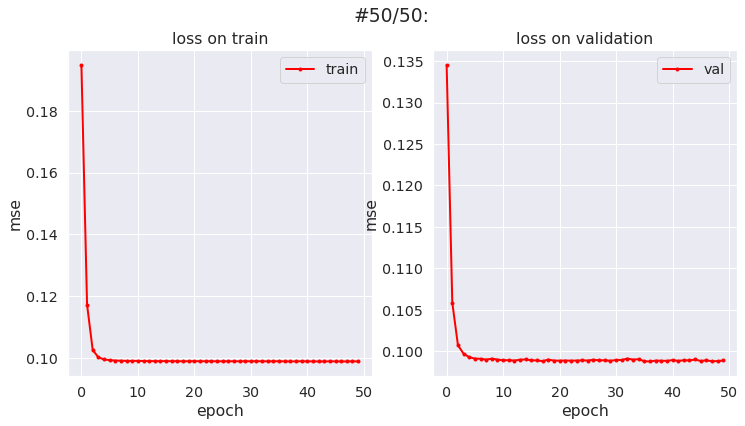

In [ ]:
model, optimizer, losses = learning_loop(
    model = model,
    optimizer = optimizer,
    loader = dataloader,
    criterion = criterion,
    epochs=50,
    draw_every=10,
    separate_show=True,
    device=device
)

In [ ]:
visualize_predictions_go(sec_times, first_user_data['userAcceleration.x'], model, dataset, batch_size, device='cpu')

10-мерная

In [ ]:
in_len = steps_in_time
hid_dim = 10
out_len = steps_in_time

batch_size = 16
lr = 1e-3

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)

dataset = TimeSerie_1d_Dataset(in_len=in_len, 
                               out_len=out_len, 
                               s_noice=first_user_data['userAcceleration.x'], 
                               s_true=None)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = NN_2(in_len=in_len, hid_dim=hid_dim, out_len=out_len).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

cpu


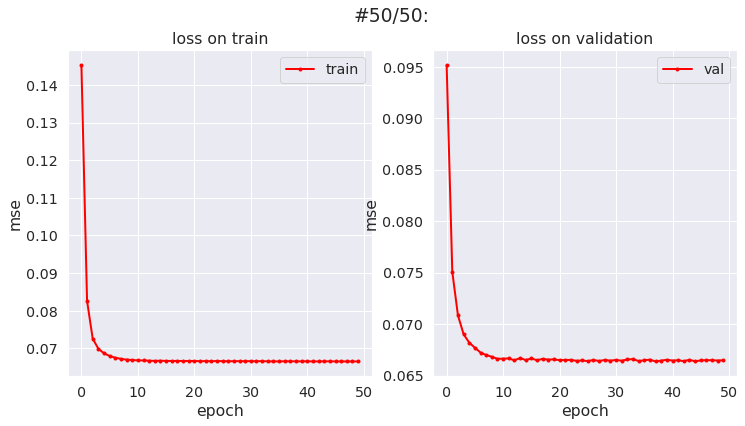

In [ ]:
model, optimizer, losses = learning_loop(
    model = model,
    optimizer = optimizer,
    loader = dataloader,
    criterion = criterion,
    epochs=50,
    draw_every=10,
    separate_show=True,
    device=device
)

In [ ]:
visualize_predictions_go(sec_times, first_user_data['userAcceleration.x'], model, dataset, batch_size, device='cpu')

#### 4. Байесовская сеть

In [ ]:
!pip install torchbnn